Prediction Evaluation

In [17]:
import os
from pathlib import Path
import codecs
import json
from typing import List, Dict, Any
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm.notebook import trange, tqdm

benchmarks_dir = '../benchmarks'
import pymongo
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pymongo import MongoClient

font_name = "Source Sans Pro"
plt.rcParams['font.size'] = 15
plt.rcParams['font.sans-serif'] = [font_name, 'Fira Sans']
plt.rcParams['font.weight'] = 'regular'

# Wrong binary operand
artificial_deepbugs_predictions_fp = os.path.join(benchmarks_dir,
                                                  'evaluated_real_bugs_artificial_wrong_IncorrectBinaryOperand.json')
semseed_deepbugs_predictions_fp = os.path.join(benchmarks_dir,
                                               'evaluated_real_bugs_semseed_wrong_IncorrectBinaryOperand.json')

# Wrong assignments
semseed_deepbugs_predictions_fp_wrong_assignments = os.path.join(benchmarks_dir,
                                                                 'evaluated_real_bugs_semseed_wrong_IncorrectAssignment.json')
artificial_predictions_fp_wrong_assignments = os.path.join(benchmarks_dir,
                                                           'evaluated_real_bugs_artificial_wrong_IncorrectAssignment.json')

In [2]:
colors = ["#fb1700", "#34626c", "#F77F00", "#FCBF49", "#EAE2B7"]
sns.set_palette(sns.set_palette(sns.color_palette(colors)))

In [3]:
def plot_precision_recall(precision_and_recalls, bug_type, precision_or_recall, annotation_idx):
    font_name = "Source Sans Pro"

    plt.rcParams['font.size'] = 20
    plt.rcParams['font.sans-serif'] = [font_name, 'sans-serif']
    plt.rcParams['font.weight'] = 'medium'

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    types_of_thresholds = []
    num_bug_seeding = len(precision_and_recalls['Bug-Seeding Approach'].unique())
    for i in range(num_bug_seeding):
        ar = np.arange(0, 1.1, 0.1)
        types_of_thresholds.append(ar)
    x = np.concatenate(types_of_thresholds)
    #sns.set_palette("dark")

    semseed_results = precision_and_recalls.groupby(['Bug-Seeding Approach']).agg(list)[precision_or_recall]['SemSeed']
    ax = sns.lineplot(x=np.arange(0, 1.1, 0.1), y=semseed_results)

    # [precision_wrong_binopnd, recall_wrong_binopnd, precison_wrong_assingment, recall_wrong_assignment]
    x_y_semseed = [(0.65, 0.51), (.52, .51), (.72, .56), (.72, .51)][annotation_idx]
    x_y_artificial = [(0.75, 0.71), (.19, .4), (.77, .2), (.34, .51)][annotation_idx]

    ax.annotate('SemSeed',
                xy=x_y_semseed, color=colors[0], xycoords='data')
    ax.set_ylim(0, 1.0)

    artificial_results = precision_and_recalls.groupby(['Bug-Seeding Approach']).agg(list)[precision_or_recall][
        'Artificial']
    ax = sns.lineplot(x=np.arange(0, 1.1, 0.1), y=artificial_results)
    ax.annotate('Artificial',
                xy=x_y_artificial, color=colors[1], xycoords='data')
    ax.set_ylim(0, 1.0)
    # ax.annotate('Aritificial',
    #                 xy=(0.9, 0.5), xycoords='Aritificial')
    #ax = plt.stackplot(x=precision_and_recalls['x'], y='Recall', x=x, style='Bug-Seeding Approach')
    # legend = ax.legend()
    #
    # legend.texts[0].set_text("Semseed")
    # legend.texts[1].set_text("Artificial")
    # ax.text(0.35, 0.95, text, fontsize=15, fontweight='bold')
    ax.set(xlabel="Threshold for classifying a bug", ylabel=precision_or_recall)

    ax.xaxis.label.set_size(22)
    ax.yaxis.label.set_size(22)
    # ax.annotate('Random', xy=(0.01, 0.01), xytext=(0.15, 0.15), textcoords='axes fraction',
    #             arrowprops=dict(facecolor=sns.color_palette('dark')[6], shrink=0.05, width=3.5, headwidth=9),
    #             fontsize=14,
    #             fontweight='normal')
    plt.savefig(os.path.join(benchmarks_dir, f'precision_recall_{bug_type}_{precision_or_recall}.pdf'),
                transparent=True,
                bbox_inches='tight')
    plt.show()
    # plt.savefig(os.path.join(benchmarks_dir, 'precision_vs_recall.pdf'), transparent=True,
    #             bbox_inches='tight')


def get_precision_recall_different_threshold(bug_reports):
    p, r = [], []
    thresholds = np.arange(0, 1.1, 0.1)
    for t in thresholds:
        pr, rc, fs = get_precision_recall(bug_reports, t)
        p.append(pr)
        r.append(rc)
    return p, r

In [4]:
def plot_recall_at_different_threshold(prec_recalls, bug_type):
    num_bug_seeding = len(prec_recalls['Bug-Seeding Approach'].unique())
    types_of_thresholds = []
    for i in range(num_bug_seeding):
        ar = np.arange(0, 1.1, 0.1)
        types_of_thresholds.append(ar)
    x = np.concatenate(types_of_thresholds)
    sns.lineplot(x, y='Recall', hue='Bug-Seeding Approach', data=prec_recalls)
    plt.savefig(os.path.join(benchmarks_dir, f'recall_{bug_type}.pdf'), transparent=True,
                bbox_inches='tight')
    plt.show()


def plot_precision_at_different_threshold(prec_recalls, bug_type):
    num_bug_seeding = len(prec_recalls['Bug-Seeding Approach'].unique())
    types_of_thresholds = []
    for i in range(num_bug_seeding):
        ar = np.arange(0, 1.1, 0.1)
        types_of_thresholds.append(ar)
    x = np.concatenate(types_of_thresholds)
    sns.lineplot(x, y='Precision', hue='Bug-Seeding Approach', data=prec_recalls)
    plt.savefig(os.path.join(benchmarks_dir, f'precision_{bug_type}.pdf'), transparent=True,
                bbox_inches='tight')
    plt.show()

In [5]:
def read_json(file_path):
    with open(file_path, 'r') as f:
        c = json.load(f)
    return c


def get_precision_recall(predictions: pd.DataFrame, t):
    true_values = []
    pred_values = []
    precision, recall, fscore = 0, 0, 0
    for _, row in predictions.iterrows():
        true_values.append(row['buggy'])
        if row['p_buggy'] > t:
            pred_values.append(1)
        else:
            pred_values.append(0)
    tp, fp, tn, fn = 0, 0, 0, 0
    for tv, pv in zip(true_values, pred_values):
        if tv == 1 == pv:
            tp += 1
        if tv == 0 and pv == 1:
            fp += 1
        if tv == 0 and pv == 0:
            tn += 1
        if tv == 1 and pv == 0:
            fn += 1
    if (tp + fp):
        precision = tp / (tp + fp)
    if (tp + fn):
        recall = tp / (tp + fn)
    if precision + recall:
        fscore = (2 * precision * recall) / (precision + recall)
    return precision, recall, fscore

## Wrong Binary Operand

#### SemSeed

In [6]:
def get_data_for_semseed_wrong_operand():
    semseed_bugs = read_json(semseed_deepbugs_predictions_fp)
    print(f'Found  {len(semseed_bugs)} semseed bugs')
    semseed_bugs = pd.DataFrame(semseed_bugs)
    p, r = get_precision_recall_different_threshold(semseed_bugs)
    semseed_wrong_binary_operand_p_r = {
        'Precision': p,
        'Recall': r,
        'Bug-Seeding Approach': ['SemSeed'] * len(p)
    }
    return semseed_wrong_binary_operand_p_r, semseed_bugs

#### Artificial

In [7]:
def get_data_for_aritficial_wrong_operand():
    artificial_bugs = read_json(artificial_deepbugs_predictions_fp)
    print(f'Found  {len(artificial_bugs)} artificial bugs')
    artificial_bugs = pd.DataFrame(artificial_bugs)
    p, r = get_precision_recall_different_threshold(artificial_bugs)
    artificial_wrong_binary_operand_p_r = {
        'Precision': p,
        'Recall': r,
        'Bug-Seeding Approach': ['Artificial'] * len(p)
    }
    return artificial_wrong_binary_operand_p_r, artificial_bugs

In [8]:
artificial_wrong_binary_operand_p_r, artificial_bugs_wrong_opnd = get_data_for_aritficial_wrong_operand()
semseed_wrong_binary_operand_pr_r, semseed_bugs_wrong_opnd = get_data_for_semseed_wrong_operand()

artificial_wrong_binary_operand_p_r = pd.DataFrame(artificial_wrong_binary_operand_p_r)
semseed_wrong_binary_operand_pr_r = pd.DataFrame(semseed_wrong_binary_operand_pr_r)
wrong_operand_bugs_pr_recall = pd.concat((artificial_wrong_binary_operand_p_r, semseed_wrong_binary_operand_pr_r),
                                         ignore_index=True)
wrong_operand_bugs_pr_recall

Found  754 artificial bugs
Found  754 semseed bugs


,Precision,Recall,Bug-Seeding Approach
0,0.500000,1.000000,Artificial
1,0.501171,0.567639,Artificial
2,0.478261,0.320955,Artificial
3,0.459259,0.164456,Artificial
4,0.505882,0.114058,Artificial
5,0.454545,0.079576,Artificial
6,0.515152,0.045093,Artificial
7,0.625000,0.039788,Artificial
8,0.684211,0.034483,Artificial
9,0.692308,0.023873,Artificial


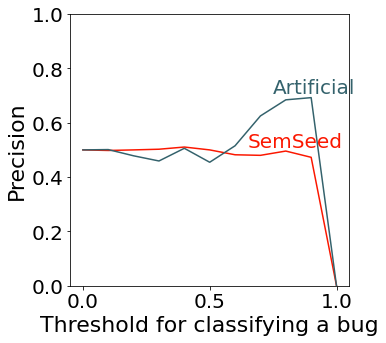

In [19]:
plot_precision_recall(wrong_operand_bugs_pr_recall, 'wrong_binopnd', 'Precision', 0)

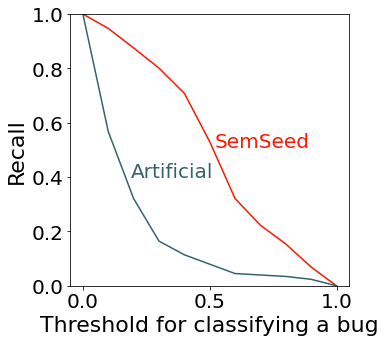

In [11]:
plot_precision_recall(wrong_operand_bugs_pr_recall, 'wrong_binopnd', 'Recall', 1)

## Wrong Assignment bugs

#### SemSeed

In [12]:
def get_data_semseed_wrong_assignment():
    semseed_bugs_wrng_assgnmnts = read_json(semseed_deepbugs_predictions_fp_wrong_assignments)
    filtered_prediction = []
    for prediction in semseed_bugs_wrng_assgnmnts:
        filtered_prediction.append(prediction)
    semseed_bugs_wrng_assgnmnts = pd.DataFrame(filtered_prediction)
    p, r = get_precision_recall_different_threshold(semseed_bugs_wrng_assgnmnts)
    semseed_wrong_assignment_p_r = {
        'Precision': p,
        'Recall': r,
        'Bug-Seeding Approach': ['SemSeed'] * len(p)
    }
    return semseed_wrong_assignment_p_r, semseed_bugs_wrng_assgnmnts

#### Aritificial

In [13]:
def get_data_artificial_wrong_assignment():
    artificial_bugs_wrng_assgnmnts = read_json(artificial_predictions_fp_wrong_assignments)
    
    filtered_prediction = []
    for prediction in artificial_bugs_wrng_assgnmnts:
        filtered_prediction.append(prediction)
    
    artificial_bugs_wrng_assgnmnts = pd.DataFrame(filtered_prediction)
    p, r = get_precision_recall_different_threshold(artificial_bugs_wrng_assgnmnts)
    artificial_wrong_assignment_p_r = {
        'Precision': p,
        'Recall': r,
        'Bug-Seeding Approach': ['Artificial'] * len(p)
    }
    return artificial_wrong_assignment_p_r, artificial_bugs_wrng_assgnmnts


In [14]:
artificial_wrong_assignments_p_r, art_wrong_assignments = get_data_artificial_wrong_assignment()
semseed_wrong_assignments_p_r, semseed_wrong_assignments = get_data_semseed_wrong_assignment()

artificial_wrong_assignments_p_r = pd.DataFrame(artificial_wrong_assignments_p_r)
semseed_wrong_assignments_p_r = pd.DataFrame(semseed_wrong_assignments_p_r)
wrong_assignment_bugs = pd.concat((artificial_wrong_assignments_p_r, semseed_wrong_assignments_p_r), ignore_index=True)
wrong_assignment_bugs

,Precision,Recall,Bug-Seeding Approach
0,0.500000,1.000000,Artificial
1,0.523077,0.894737,Artificial
2,0.509091,0.736842,Artificial
3,0.512195,0.552632,Artificial
4,0.560000,0.368421,Artificial
5,0.533333,0.210526,Artificial
6,0.333333,0.052632,Artificial
7,0.500000,0.052632,Artificial
8,0.000000,0.000000,Artificial
9,0.000000,0.000000,Artificial


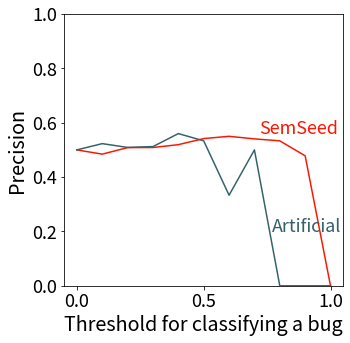

In [36]:
plot_precision_recall(wrong_assignment_bugs, 'wrong_assignment', 'Precision', 2)

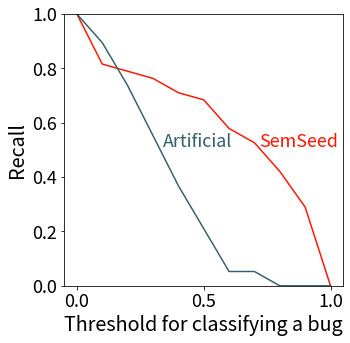

In [37]:
plot_precision_recall(wrong_assignment_bugs, 'wrong_assignment', 'Recall', 3)